In [1]:
class NeuralNetMLP(object):
    def __init__(self, n_hidden = 30, l2 = 0., epochs =100,
                 eta = 0.001, shuffle = True, minibatch_size = 1, seed = None):
        self.random = np.random.RandomState(seed)
        self.n_hidden = n_hidden
        self.l2 = l2
        self.epochs = epochs
        self.eta = eta
        self.shuffle = shuffle
        self.minibatch_size = minibatch_size
        
    def _onehot(self, y, n_classes):
        onehot = np.zeros((n_classes, y.shape[0]))
        for idx, val in enumerate(y.astype(int)):
           onehot[val, idx] = 1
        return onehot.T
    
    def _sigmoid(self, z):
        return 1./(1. + np.exp(-np.clip(z, -250, 250)))
    
    def _forward(self, X):
        z_h = np.dot(X, self.w_h) + self.b_h
        a_h = self._sigmoid(z_h)
        z_out = np.dot(a_h, self.w_out) + self.b_out
        a_out = self._sigmoid(z_out)
        return z_h, a_h, z_out, a_out
    
    def _cost(self, y_enc, out_put):
        L2_term = self.l2 * (np.sum(self.w_h ** 2.) +  np.sum(self.w_out ** 2.))
        x1  = -y_enc * np.log(out_put)
        x2 = (1-y_enc) * np.log(1 - out_put)
        return np.sum(x1 - x2) + L2_term
    
    def predict(self, X):
        z_h, a_h, z_out, a_out = self._forward(X)
        y_pred = np.argmax(z_out, axis = 1)
        return y_pred
    
    def fit(self, X_train, y_train, X_valid, y_valid):
        n_output = np.unique(y_train).shape[0]
        n_features = X_train.shape[1]
        
        self.b_h = np.zeros(self.n_hidden)
        self.w_h = self.random.normal(loc = 0, scale = 0.1, size = (n_features, self.n_hidden))
        
        self.b_out = np.zeros(n_output)
        self.w_out = self.random.normal(loc = 0, scale = 0.1, size = (self.n_hidden, n_output))
        
        epoch_strlen = len(str(self.epochs))
        self.eval_ = {'cost':[], 'train_accuracy':[], 'valid_accuracy': []}
        y_train_enc = self._onehot(y_train, n_output)
        
        for i in range(self.epochs):
            indices = np.arange(X_train.shape[0])
            
            if self.shuffle:
                self.random.shuffle(indices)
                
            for start_idx in range(0, indices.shape[0] - self.minibatch_size + 1, self.minibatch_size):
                batch_idx = indices[start_idx : start_idx + self.minibatch_size]
                z_h, a_h, z_out, a_out  = self._forward(X_train[batch_idx])
                y_pred = self.predict(X_train[batch_idx])
                
                delta_out = (a_out - y_train_enc[batch_idx])*a_out*(1-a_out)
                sigmoid_derivative = a_h * (1. - a_h)
                
                delta_h = (np.dot(delta_out, self.w_out.T) * sigmoid_derivative)
                
                grad_w_h = np.dot(X_train[batch_idx].T, delta_h)
                grad_b_h = np.sum(delta_h, axis = 0)
                grad_w_out = np.dot(a_h.T, delta_out)
                grad_b_out = np.sum(delta_out, axis = 0)
                
                delta_w_h = (grad_w_h + self.l2*self.w_h)
                delta_b_h = grad_b_h # bias is not regularized
                self.w_h -= self.eta * delta_w_h
                self.b_h -= self.eta * delta_b_h

                delta_w_out = (grad_w_out + self.l2*self.w_out)
                delta_b_out = grad_b_out  # bias is not regularized
                self.w_out -= self.eta * delta_w_out
                self.b_out -= self.eta * delta_b_out
            
            
            
            z_h, a_h, z_out, a_out = self._forward(X_train)
            cost = self._cost(y_train_enc, a_out)
            y_train_pred = self.predict(X_train)
            y_valid_pred = self.predict(X_valid)
            
            train_acc = ((np.sum(y_train == y_train_pred)).astype(np.float) /
                         X_train.shape[0])
            valid_acc = ((np.sum(y_valid == y_valid_pred)).astype(np.float) /
                         X_valid.shape[0])
            sys.stderr.write('\r%0*d/%d | Cost: %.2f '
                             '| Train/Valid Acc.: %.2f%%/%.2f%% ' %
                             (epoch_strlen, i+1, self.epochs, cost,
                              train_acc*100, valid_acc*100))
            sys.stderr.flush()

            self.eval_['cost'].append(cost)
            self.eval_['train_accuracy'].append(train_acc)
            self.eval_['valid_accuracy'].append(valid_acc)
        return self
    

In [5]:
import joblib
import matplotlib.pyplot as plt
import cv2
model = joblib.load('Recognition.pkl')

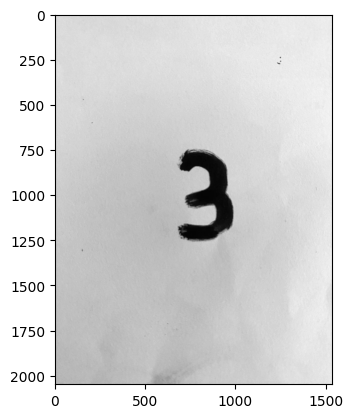

In [118]:
file = r'3.jpg'
test_image = cv2.imread(file, cv2.IMREAD_GRAYSCALE)
plt.imshow(test_image, cmap = 'gray')

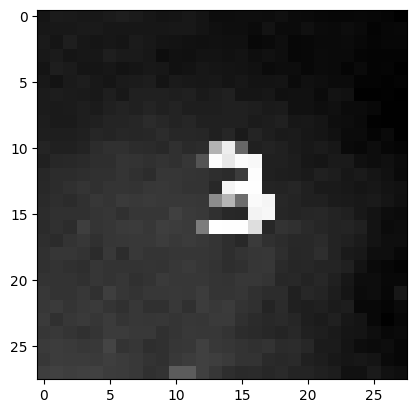

In [119]:
img_resize = cv2.resize(test_image, (28,28), interpolation = cv2.INTER_LINEAR)
img_resize = cv2.bitwise_not(img_resize)
plt.imshow(img_resize, cmap = 'gray')

In [120]:
import numpy as np
print(model.predict(img_resize.reshape(1,28*28)))


[3]
